Moving away from `blochstate`.

In [1]:
# import all the E9 stuff
import logging
import numpy as np
import matplotlib.pyplot as plt
import sys
from pathlib import Path
import time
from scipy.linalg import eigh

# User defined modules
E9path = Path("C:/", "Users", "ken92", "Documents", "Studies", "E5", "simulation", "E9_simulations")
if str(E9path) not in sys.path:
    sys.path.insert(1, str(E9path))
import E9_fn.E9_constants as E9c
import E9_fn.E9_atom as E9a
import E9_fn.E9_cooltrap as E9ct
import E9_fn.plane_wave_expansion.blochstate_class as bsc
# import E9_fn.polarizabilities_calculation as E9pol
# import E9_fn.datasets.transition_line_data as TLData
from E9_fn import util

# Logging
logpath = '' # '' if not logging to a file
loglevel = logging.INFO
logroot = logging.getLogger()
list(map(logroot.removeHandler, logroot.handlers))
list(map(logroot.removeFilter, logroot.filters))
logging.basicConfig(filename = logpath, level = loglevel)

c:\Users\ken92\Documents\Studies\E5\simulation\E9_simulations\.venv\Lib\site-packages\gftool\precision.py:16: UserWarning: No quad precision datatypes available!
Some functions might be less accurate.
  warnings.warn("No quad precision datatypes available!\n"


# Inputs

In [3]:
species = "K40" # "Rb87", "K40"

# lattice parameters
V1064Er = 9.            # 1064 lattice depth, in recoil energy
V532Er = 0.             # 532 lattice depth, in recoil energy
n0nom = 0               # peak density
# The superlattice phase that determines the relative position between 1064 and 532 lattice
# 532 lattice is fixed at 0, so changing the pase by pi for 1064 restores the original lattice
phi12, phi23 = 0., 0.
# phi12, phi23 = np.pi*2/3, -np.pi*2/3    # decorated triangular lattice
ABoffset1064nom = 0     # max 0.011585 * V1064nom / 9 / np.sqrt(3) for Rb
B1_rel_int_1064 = 1     # relative intensity (field is sqrt of that) of 1064 B1
B1_rel_int_532  = 1     # relative intensity (field is sqrt of that) of 532 B1
B3_rel_int_1064 = 1     # relative intensity (field is sqrt of that) of 1064 B3
B3_rel_int_532  = 1     # relative intensity (field is sqrt of that) of 532 B3

# Basic simulation parameters
num = 6             # size of q-momentum space we consider: (-num, num) (usually 5)
k_center = (0, 0)
bandstart = 0       # starting from 0, inclusive
bandend = 3         # inclusive
qverts_str = 'E9c.Kp/E9c.k_lw, E9c.Kp2/E9c.k_lw, E9c.Kp3/E9c.k_lw, E9c.Kp4/E9c.k_lw, E9c.Kp5/E9c.k_lw, E9c.Kp6/E9c.k_lw, E9c.Kp/E9c.k_lw'

# Initialization
## Units

In [4]:
if species == "Rb87":
    all_units_dict = E9c.all_lat_unit_Rb87
    Er_1064 = E9c.E_r1064_Rb87
    Er_532 = E9c.E_r532_Rb87
elif species == "K40":
    all_units_dict = E9c.all_lat_unit_K40
    Er_1064 = E9c.E_r1064_K40
    Er_532 = E9c.E_r532_K40
else:
    raise ValueError("Unknown species: {}".format(species))
m_unit = all_units_dict["m_unit"]
l_unit = all_units_dict["l_unit"]
E_unit = all_units_dict["E_unit"]
f_unit = all_units_dict["f_unit"]
t_unit = all_units_dict["t_unit"]

V532nom = V532Er * Er_532 / E9c.hnobar / 1e3       # in kHz (i.e. V_SI / hbar / 1e3 / 2pi), assuming that polarizability is accounted for correctly
V1064nom = V1064Er * Er_1064  / E9c.hnobar / 1e3   # Note that setting this to 0 doesn't give you a proper band structure of 532 nm lattice, since you are now
                                # considering too many plane waves that don't actually contribute.
V532 = 2 * np.pi * V532nom * 1e3 / f_unit   # 2 * np.pi because I have f = E/hbar instead of E/h as normally defined
V1064 = 2 * np.pi * V1064nom * 1e3 / f_unit
ABoffset1064 = 2 * np.pi * ABoffset1064nom * 1e3 / f_unit
n0 = n0nom * l_unit**3

In [5]:
Exp_lib = {"species": species, "units_dict": all_units_dict
        , 'V532nom': V532nom, 'V1064nom': V1064nom, 'V532': V532, 'V1064': V1064
        , 'B1_rel_int_532': B1_rel_int_532, 'B1_rel_int_1064': B1_rel_int_1064 , 'B3_rel_int_532': B3_rel_int_532, 'B3_rel_int_1064': B3_rel_int_1064
        , 'n0nom': n0nom, 'n0': n0
        , 'ABoffset1064nom': ABoffset1064nom, 'ABoffset1064': ABoffset1064
        , 'phi12': phi12, 'phi23': phi23}

size = 2 * num + 1
bandnum = bandend - bandstart + 1 # number of bands interested in
qverts_arr = eval(qverts_str)

In [6]:
def MinimumGap(e_values, band1, band2):
    """Prints the position and energy of the minimum gap.
    
    Example: MinimumGap(e_values,2,3)
    Should be slightly enhanced to return something
    """
    gaps = e_values[:, band2] - e_values[:, band1]
    print('The minimum band gap between band{} and band{} is {} kHz, happening at the {} (python index) q evaluated' \
          .format(band1, band2, gaps.min() * f_unit / 1e3 / (2 * np.pi), gaps.argmin()))

def find_q_geo_tensor(n_q, n_band, Exp_lib, q_list, E_list, psi_list, Hq_mmat, Hq_nmat, component = 'xx'):
    """Find the quantum geometric tensor for a given Bloch state psi."""
    q = q_list[n_q]
    psin = psi_list[n_q, :, n_band]
    En = E_list[n_q, n_band]
    dH1 = bsc.find_del_H(q, Exp_lib, Hq_mmat, Hq_nmat, direction = component[0])
    dH2 = bsc.find_del_H(q, Exp_lib, Hq_mmat, Hq_nmat, direction = component[1])
    qgt = 0j
    for m_band in range(E_list.shape[1]):
        if m_band == n_band:
            continue
        psim = psi_list[n_q, :, m_band]
        Em = E_list[n_q, m_band]
        qgt += psim.conj() @ dH1 @ psin * psin.conj() @ dH2 @ psim / (Em - En)**2
    if not util.IsHermitian(qgt):
        logging.warning(f"Quantum geometric tensor for n_band {n_band}, n_q {n_q} is not Hermitian")
    return qgt

# Real space plots

Pretty sure that the orientation is still wrong - maybe flipped about $x = 0$?

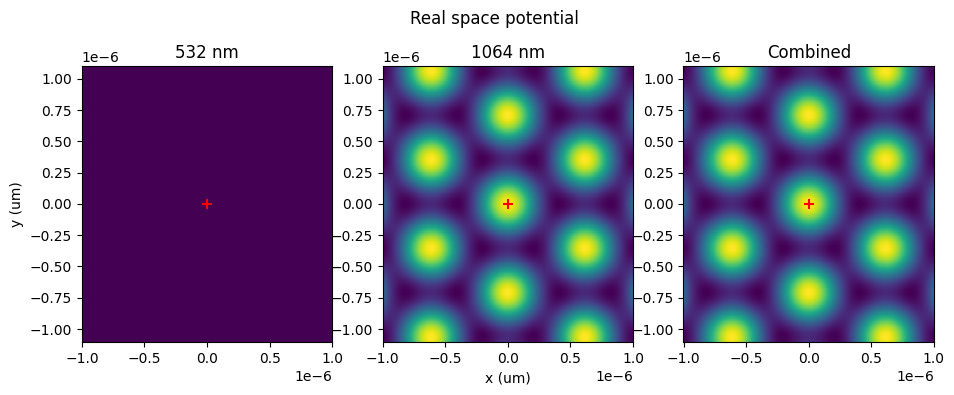

In [7]:
x_real = np.linspace(-1, 1, 500) * 1e-6
y_real = np.linspace(-1.1, 1.1, 500) * 1e-6

pos_delta = E9c.a_lw_hex * E9c.k1k * (phi12 / 2 / np.pi) + E9c.a_lw_hex * E9c.k3k * (phi23 / 2 / np.pi)
x_delta, y_delta = pos_delta # should be simple functions of phi12 and phi23
V_532_real = bsc.get_Vin(x_real, y_real, V532, B1_rel_int_532, B3_rel_int_532, 0, 0, 1)
V_1064_real = - bsc.get_Vin(x_real, y_real, V1064, B1_rel_int_1064, B3_rel_int_1064, x_delta, y_delta, 2)
V_super_real = V_532_real + V_1064_real
fig_real = plt.figure(figsize = (11, 4))
ax_532 = fig_real.add_subplot(131, aspect = "equal")
ax_1064 = fig_real.add_subplot(132, aspect = "equal")
ax_super = fig_real.add_subplot(133, aspect = "equal")
fig_real.suptitle("Real space potential")
ax_532.set_ylabel("y (um)")
ax_1064.set_xlabel("x (um)")

for ax, V_real, ax_title in zip([ax_532, ax_1064, ax_super],
                                [V_532_real, V_1064_real, V_super_real],
                                ["532 nm", "1064 nm", "Combined"]):
    im = ax.pcolormesh(x_real, y_real, V_real, cmap = 'viridis')
    ax.scatter(0, 0, color = 'red', marker = '+', s = 50)
    ax.set_title(ax_title)
    # fig_real.colorbar(im, ax = ax)
    

# Finding Bloch states and band energies

Total number of points = 1047


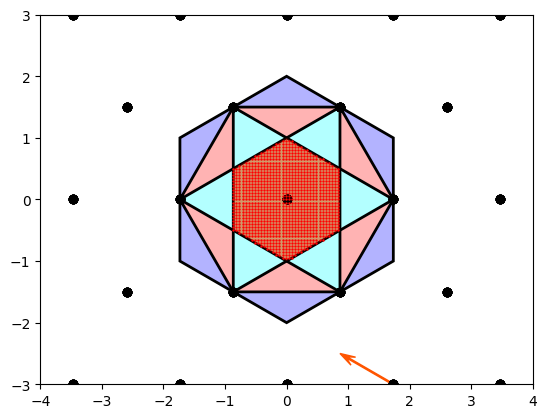

--- 3.7206361293792725 seconds ---


In [8]:
start_time = time.time()

# Generate qset
dq = 0.05
qsets = bsc.FindqArea(qverts_arr, dqx = dq, dqy = dq)
print("Total number of points = {0}".format(len(qsets)))
PlotBZinput = (qverts_str, qsets)
ax_BZ = bsc.PlotBZ(qset = PlotBZinput)

# find non-interacting solution
e_values = np.zeros((len(qsets), bandnum), dtype = np.cdouble)
e_states = np.zeros((len(qsets), size**2, bandnum), dtype = np.cdouble)

Hq_mmat, Hq_nmat, H_532, H_1064 = bsc.find_H_components(num, Exp_lib, center = k_center)
for i in range(len(qsets)):
    H = bsc.find_H(qsets[i], Exp_lib, Hq_mmat, Hq_nmat, H_532, H_1064)
    assert util.IsHermitian(H)
    e_values[i,:], e_states[i,:,:] = eigh(H, eigvals = (bandstart, bandend),
                                          overwrite_a = True, check_finite = False)

print("--- {0} seconds ---".format((time.time() - start_time)))

I always get a `ComplexWarning` when running `.astype(np.double)`, but if my own check doesn't raise a warning all is good.

In [9]:
if not np.all(np.isreal(e_values)):
    logging.warning('Complex eigenvalue detected. Imaginary parts are discarded.')
e_values = e_values.astype(np.double)

C:\Users\ken92\AppData\Local\Temp\ipykernel_18196\1078986975.py:3: ComplexWarning: Casting complex values to real discards the imaginary part
  e_values = e_values.astype(np.double)


# Plots

## Band structure

Text(0.5, 0.92, 'V532 = 0.0 kHz, V1064 = 39.68873534078824 kHz; AB offset = 0.0 kHz\nn0 = 0; (-6,6)_(0, 0); phi = (0.0,0.0)')

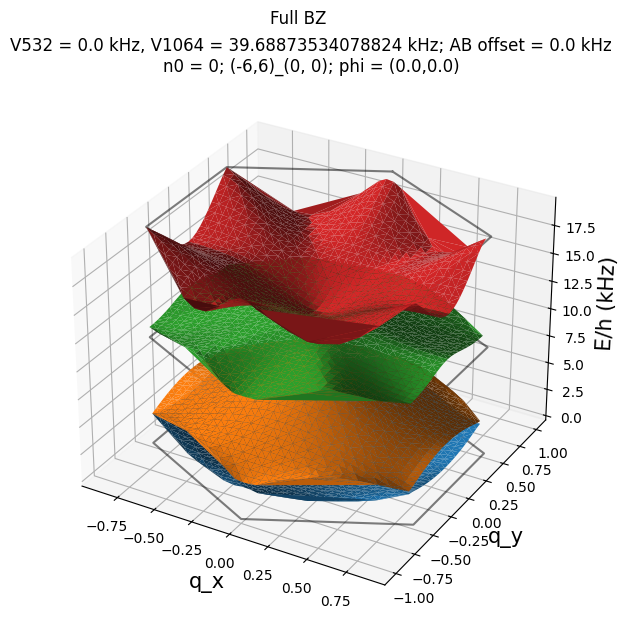

In [14]:
f2kHz = f_unit / 1e3 / (2 * np.pi) # conversion factor from natural units to kHz
E_lowest = np.min(e_values)
E_kHz_offset = (e_values - E_lowest) * f2kHz
E_kHz_highest = np.max(E_kHz_offset)
fig_E = plt.figure(0, figsize=(10,7))
fig_E.clf()
fig_E.suptitle("Full BZ")

ax_E = fig_E.add_subplot(111, projection = '3d')
# Add BZ boundary
bz1qx, bz1qy = [q[0] for q in E9c.BZ1_vertices], [q[1] for q in E9c.BZ1_vertices]
for i in range(3):
    ax_E.plot(bz1qx, bz1qy, np.ones_like(bz1qx) * E_kHz_highest * i / 2, '-k', alpha = 0.5)
for i in range(bandnum):
    ax_E.plot_trisurf(qsets[:, 0], qsets[:, 1], E_kHz_offset[:, i]) # TODO: try plotly
ax_E.set_xlabel('q_x', fontsize = 15)
ax_E.set_ylabel('q_y', fontsize = 15)
ax_E.set_zlabel('E/h (kHz)', fontsize = 15)

ax_E.set_title('V532 = {} kHz, V1064 = {} kHz; AB offset = {:.4} kHz\nn0 = {}; (-{},{})_{}; phi = ({:.4},{:.4})'.format(V532nom, V1064nom, float(ABoffset1064nom), n0nom, num, num, k_center, phi12, phi23))

## Bloch state

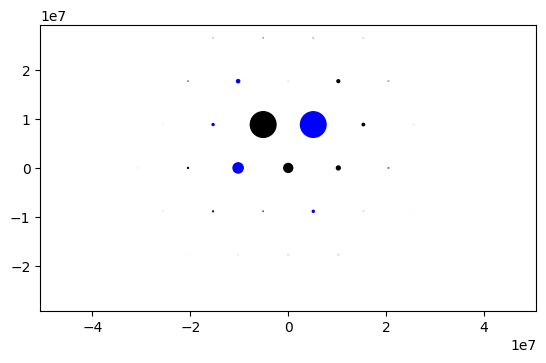

In [11]:
fig_ToF = plt.figure()
ax_ToF = fig_ToF.add_subplot(111)
# bsc.ToFSubplot(ax_ToF, bsc.FindInStateList(e_states_ni[1], E9c.Kp*0.5, 1))
bsc.ToFSubplot(ax_ToF, e_states[30,:,1])

## Quantum metric tensor

In [12]:
bool_find_QMT = False

In [13]:
if bool_find_QMT:
    qgts_xx = np.zeros((len(qsets), bandnum), dtype = np.cdouble)
    for i in range(len(qsets)):
        for j in range(bandnum):
            qgts_xx[i, j] = find_q_geo_tensor(i, j, Exp_lib, qsets, e_values, e_states, Hq_mmat, Hq_nmat)
    qmts_xx = np.real(qgts_xx)                # quantum metric tensor
    berry_curvs_xx = - 2 * np.imag(qgts_xx)   # Berry curvature

    fig_qgt = plt.figure(2, figsize=(10,7))
    fig_qgt.clf()
    ax_qgt = fig_qgt.add_subplot(111)
    ax_qgt.set_title('Quantum geometric tensor')
    ax_qgt.plot(xq, qmts_xx[:, 2], label = 'qmts_00')